In [393]:
from typing import List, Tuple

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.regression as smreg
import matplotlib.pyplot as plt

In [394]:
df = pd.read_csv("pt2_data.csv", sep=';', header=0, decimal=',')

In [395]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   xi      70 non-null     float64
 1   yi      70 non-null     float64
 2   zi      70 non-null     float64
dtypes: float64(3)
memory usage: 1.8 KB


### Část a)

In [396]:
def try_model(features):
    """Sestaví model podle vstupní n-tice určující přítomnost jednotlivých
     parametrů (X, Y, X², Y², XY) a 'natrénuje' jej daty z df."""
    formula = "zi ~ 1 + " + ("xi + " if features[0] else "") + ("yi + " if features[1] else "") + (
        "np.square(xi) + " if features[2] else "") \
              + ("np.square(yi) + " if features[3] else "") + ("(xi : yi) + " if features[4] else "")
    formula = formula[:-3]

    mod = smf.ols(formula=formula, data=df)
    return mod.fit(), formula


def zeroish_params(result, alpha=0.05):
    """Pomocí t-testu otestuje, zda se parametry modelu na dané hladině významnosti rovnají nule."""
    names = {'Intercept': '1', 'xi': '2', 'yi': '3',
             'np.square(xi)': '4', 'np.square(yi)': '5', 'xi:yi': '6'}
    pvals = result.pvalues
    par_idx = 0
    has = False
    for pval in pvals:
        # Pokud je p-hodnota větší než zadaná hladina významnosti, hypotézu o nulovosti nezamítáme
        if pval > alpha:
            par_name = result.params.axes[0].values[par_idx]
            print(f">>> β̂_{names[par_name]} (for {par_name}) may be zero-ish (p-val = {round(pval, 4)})")
            has = True
        par_idx += 1
    if not has:
        print(">>> no zero-ish parameters")

In [397]:
configs = {}

# Vytvoříme všech 32 možných modelů
for i in range(2 ** 5):
    config = (i & 2 ** 4 != 0, i & 2 ** 3 != 0, i & 2 ** 2 != 0, i & 2 != 0, i & 1 == 1)
    model_result, form = try_model(config)
    configs[form] = model_result

In [398]:
def show_sorted_by(selector, selector_name, top_n):
    """Vypíše informace o top_n modelech seřazených podle dané zadané funkce."""
    configs_sorted: List[Tuple[str, smreg.linear_model.RegressionResults]] \
        = sorted(configs.items(), key=lambda x: selector(x[1]), reverse=True)

    print(f"Top {top_n} (by {selector_name}):")
    conf_idx = 0
    for config_tuple in configs_sorted[0:top_n]:
        res = config_tuple[1]
        print(f"> {conf_idx}: {config_tuple[0]}")
        print(f">> R² = {round(res.rsquared, 5)} | R_adj² = {round(res.rsquared_adj, 5)} | F-pval = {res.f_pvalue}")
        zeroish_params(res)
        print()
        conf_idx += 1

In [399]:
# Vypíšeme prvních 5 modelů s nejvyšším koef. determinace
show_sorted_by(lambda x: x.rsquared, "R²", 30)

Top 30 (by R²):
> 0: zi ~ 1 + xi + yi + np.square(xi) + np.square(yi) + (xi : yi)
>> R² = 0.6079 | R_adj² = 0.57727 | F-pval = 6.857122749198144e-12
>>> β̂_1 (for Intercept) may be zero-ish (p-val = 0.0566)
>>> β̂_3 (for yi) may be zero-ish (p-val = 0.4536)
>>> β̂_4 (for np.square(xi)) may be zero-ish (p-val = 0.0621)
>>> β̂_6 (for xi:yi) may be zero-ish (p-val = 0.9938)

> 1: zi ~ 1 + xi + yi + np.square(xi) + np.square(yi)
>> R² = 0.6079 | R_adj² = 0.58377 | F-pval = 1.2664209617505418e-12
>>> β̂_3 (for yi) may be zero-ish (p-val = 0.4085)
>>> β̂_4 (for np.square(xi)) may be zero-ish (p-val = 0.0601)

> 2: zi ~ 1 + xi + np.square(xi) + np.square(yi) + (xi : yi)
>> R² = 0.60442 | R_adj² = 0.58007 | F-pval = 1.6789308802786497e-12
>>> β̂_1 (for Intercept) may be zero-ish (p-val = 0.0603)
>>> β̂_4 (for np.square(xi)) may be zero-ish (p-val = 0.0612)
>>> β̂_6 (for xi:yi) may be zero-ish (p-val = 0.7371)

> 3: zi ~ 1 + xi + np.square(xi) + np.square(yi)
>> R² = 0.60372 | R_adj² = 0.58571 

In [400]:
# Vypíšeme prvních 5 modelů s nejvyšším adjust. koef. determinace
show_sorted_by(lambda x: x.rsquared_adj, "R_adj²", 5)

Top 5 (by R_adj²):
> 0: zi ~ 1 + xi + np.square(xi) + np.square(yi)
>> R² = 0.60372 | R_adj² = 0.58571 | F-pval = 2.78650393646392e-13
>>> β̂_4 (for np.square(xi)) may be zero-ish (p-val = 0.0594)

> 1: zi ~ 1 + xi + yi + np.square(xi) + np.square(yi)
>> R² = 0.6079 | R_adj² = 0.58377 | F-pval = 1.2664209617505418e-12
>>> β̂_3 (for yi) may be zero-ish (p-val = 0.4085)
>>> β̂_4 (for np.square(xi)) may be zero-ish (p-val = 0.0601)

> 2: zi ~ 1 + xi + np.square(xi) + np.square(yi) + (xi : yi)
>> R² = 0.60442 | R_adj² = 0.58007 | F-pval = 1.6789308802786497e-12
>>> β̂_1 (for Intercept) may be zero-ish (p-val = 0.0603)
>>> β̂_4 (for np.square(xi)) may be zero-ish (p-val = 0.0612)
>>> β̂_6 (for xi:yi) may be zero-ish (p-val = 0.7371)

> 3: zi ~ 1 + xi + yi + np.square(xi) + np.square(yi) + (xi : yi)
>> R² = 0.6079 | R_adj² = 0.57727 | F-pval = 6.857122749198144e-12
>>> β̂_1 (for Intercept) may be zero-ish (p-val = 0.0566)
>>> β̂_3 (for yi) may be zero-ish (p-val = 0.4536)
>>> β̂_4 (for np.sq

In [401]:
# Za nejlepší model prohlásíme β1 + β2X + β4X² + β5Y²
best_model = configs["zi ~ 1 + xi + np.square(xi) + np.square(yi)"]
best_model.params

Intercept       -66.805820
xi               17.187378
np.square(xi)    -0.560746
np.square(yi)    -2.766557
dtype: float64

In [402]:
# Testy normality
from scipy.stats import kstest, norm, normaltest

ks = kstest(np.sort(best_model.resid_pearson), norm.cdf)
print(f"Kolmogorov-Smirnov: p-value = {ks.pvalue}")
print("H0 plausible (eps from normal dist.)" if ks.pvalue > 0.05 else "H0 REJECTED (eps NOT from normal dist.)")

Kolmogorov-Smirnov: p-value = 0.6820865515756823
H0 plausible (eps from normal dist.)


In [403]:
nt = normaltest(np.sort(best_model.resid_pearson))
print(f"Normaltest: p-value = {nt.pvalue}")
print("H0 plausible (eps from normal dist.)" if nt.pvalue > 0.05 else "H0 REJECTED (eps NOT from normal dist.)")

Normaltest: p-value = 0.23626813452238035
H0 plausible (eps from normal dist.)


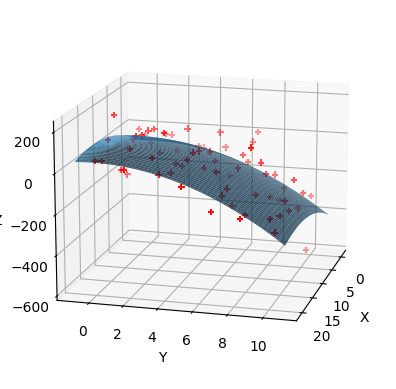

In [404]:
def plot_regression():
    X = df["xi"]
    Y = df["yi"]
    Z = df["zi"]

    ax = plt.figure().add_subplot(projection="3d")
    ax.view_init(15, 15, vertical_axis='z')

    ax.scatter(X, Y, Z, color="r", marker="+")

    x_space = np.linspace(np.min(X) - 1, np.max(X) + 1, 100)
    y_space = np.linspace(np.min(Y) - 1, np.max(Y) + 1, 100)
    x_mesh, y_mesh = np.meshgrid(x_space, y_space)

    calc_input = pd.DataFrame({'xi': x_mesh.ravel(), 'yi': y_mesh.ravel()})
    z_data = best_model.predict(exog=calc_input)

    ax.plot_surface(x_mesh, y_mesh, z_data.values.reshape(x_mesh.shape), alpha=0.8)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    #%config InlineBackend.print_figure_kwargs={'bbox_inches': None}
    plt.draw()
    plt.savefig("regression.png", dpi=300)

plot_regression()

### Část b)

In [405]:
# Informace o zvoleném modelu (včetně bodových a intervalových odhadů parametrů)
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     zi   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     33.52
Date:                Sat, 10 Dec 2022   Prob (F-statistic):           2.79e-13
Time:                        23:39:56   Log-Likelihood:                -410.51
No. Observations:                  70   AIC:                             829.0
Df Residuals:                      66   BIC:                             838.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -66.8058     28.275     -2.363      0.021    -123.259     -10.353
xi               17.1874      6.074      2.830      0.006       5.061      29.314
np.square(xi)    -0.5607      0.292     -1.918      0.059      -1.144       0.023
np.square(yi)    -2.7666      0.302     -9.147      0.000      -3.370      -2.163
==============================================================================
Omnibus:                        2.886   Durbin-Watson:                   2.365
Prob(Omnibus):                  0.236   Jarque-Bera (JB):                2.356
Skew:                          -0.179   Prob(JB):                        0.308
Kurtosis:                       3.825   Cond. No.                         534.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Část c)

In [406]:
def calc_variance_est():
    """Vypočítá bodový odhad rozptylu náh. veličiny Z podle regresního modelu."""
    s = 0
    X = df["xi"]
    for i in range(X.size):
        zi = df["zi"][i]
        a = best_model.params[0]
        b = best_model.params[1] * X[i]
        c = best_model.params[2] * X[i] ** 2
        d = best_model.params[3] * df["yi"][i] ** 2
        s += (zi - a - b - c - d) ** 2

    return s / (X.size - best_model.params.size)


# Hodnoty atributů 'scale' a 'mse_resid' evidentně také
# odpovídají bodovému odhadu rozptylu.
print("Variance point estimate:")
print(calc_variance_est())
print(best_model.scale)
print(best_model.mse_resid)

Variance point estimate:
7705.694924019383
7705.6949240193835
7705.6949240193835


### Část d), e)

In [407]:
def do_f_test(test, test_desc, alpha = 0.05):
    test = best_model.f_test(test)
    print(test_desc)
    print(f"p-value = {test.pvalue}")
    print("H0 REJECTED" if test.pvalue <= alpha else "H0 plausible")

def do_t_test(test, test_desc, alpha = 0.05):
    test = best_model.t_test(test)
    print(test_desc)
    print(f"p-value = {test.pvalue}")
    print("H0 REJECTED" if test.pvalue <= alpha else "H0 plausible")

In [408]:
do_f_test("(np.square(xi) = 0), (np.square(yi))=0", "H0: β4 = β5 = 0\nHA: β4 ≠ 0 or β5 ≠ 0")

H0: β4 = β5 = 0
HA: β4 ≠ 0 or β5 ≠ 0
p-value = 8.275717882978956e-13
H0 REJECTED


In [409]:
do_f_test("np.square(xi) = np.square(yi)", "H0: β4 = β5\nHA: β4 ≠ β5")

H0: β4 = β5
HA: β4 ≠ β5
p-value = 1.7809403222552059e-06
H0 REJECTED


In [410]:
do_t_test("np.square(xi) = np.square(yi)", "H0: β4 = β5\nHA: β4 ≠ β5")

H0: β4 = β5
HA: β4 ≠ β5
p-value = 1.7809403222552065e-06
H0 REJECTED
